# Create, evaluate, and score a fraud detection model


## Introduction

In this notebook, you walk through an end-to-end example of a R notebook. The scenario is to build a fraud detection model, using ML algorithms trained on historical data and then use the model to detect future fraudulent transactions.

This tutorial covers these steps:

- Install custom libraries.
- Load the data.
- Understand and process the data through exploratory data analysis, and demonstrate the use of the Fabric Data Wrangler feature.
- Train machine learning models by using LightGBM.
- Use the machine learning models for scoring and making predictions


## Step 1: Install custom libraries

In [3]:
install.packages("bnlearn", 
                 dependencies = TRUE,
                 version = "4.8",
                 lib = "/home/azureuser")

install.packages("imbalance",
                 version="1.0.2.1", 
                 dependencies = TRUE,
                 lib = "/home/azureuser")

install.packages("lightgbm",
                 dependencies = TRUE,
                 lib = "/home/azureuser")

Warning message:
“dependencies ‘graph’, ‘Rgraphviz’ are not available”
also installing the dependencies ‘Rmpfr’, ‘gmp’


Warning message in install.packages("bnlearn", dependencies = TRUE, version = "4.8", :
“installation of package ‘gmp’ had non-zero exit status”
Warning message in install.packages("bnlearn", dependencies = TRUE, version = "4.8", :
“installation of package ‘Rmpfr’ had non-zero exit status”


In [4]:
.libPaths("/home/azureuser")
library("bnlearn")
library("imbalance")
library("lightgbm")

## Step 2: Load the data

#### Dataset

The fraud detection dataset contains credit card transactions from September 2013, that European cardholders made over the course of two days. The dataset contains only numerical features because of a Principal Component Analysis (PCA) transformation applied to the original features. PCA transformed all features except for `Time` and `Amount`. To protect confidentiality, we can't provide the original features or more background information about the dataset.

These details describe the dataset:

 The `V1`, `V2`, `V3`, …, `V28` features are the principal components obtained with PCA
- The `Time` feature contains the elapsed seconds between a transaction and the first transaction in the dataset
- The `Amount` feature is the transaction amount. You can use this feature for example-dependent, cost-sensitive learning
- The `Class` column is the response (target) variable. It has the value `1` for fraud, and `0` otherwise

Only 492 transactions, out of 284,807 transactions total, are fraudulent. The dataset is highly imbalanced, because the minority (fraudulent) class accounts for only about 0.172% of the data.

This table shows a preview of the *creditcard.csv* data:

|Time|V1|V2|V3|V4|V5|V6|V7|V8|V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|-1.3598071336738|-0.0727811733098497|2.53634673796914|1.37815522427443|-0.338320769942518|0.462387777762292|0.239598554061257|0.0986979012610507|0.363786969611213|0.0907941719789316|-0.551599533260813|-0.617800855762348|-0.991389847235408|-0.311169353699879|1.46817697209427|-0.470400525259478|0.207971241929242|0.0257905801985591|0.403992960255733|0.251412098239705|-0.018306777944153|0.277837575558899|-0.110473910188767|0.0669280749146731|0.128539358273528|-0.189114843888824|0.133558376740387|-0.0210530534538215|149.62|"0"|
|0|1.19185711131486|0.26615071205963|0.16648011335321|0.448154078460911|0.0600176492822243|-0.0823608088155687|-0.0788029833323113|0.0851016549148104|-0.255425128109186|-0.166974414004614|1.61272666105479|1.06523531137287|0.48909501589608|-0.143772296441519|0.635558093258208|0.463917041022171|-0.114804663102346|-0.183361270123994|-0.145783041325259|-0.0690831352230203|-0.225775248033138|-0.638671952771851|0.101288021253234|-0.339846475529127|0.167170404418143|0.125894532368176|-0.00898309914322813|0.0147241691924927|2.69|"0"|


### Download the dataset and upload to the lakehouse

Define these parameters, so that you can use this notebook with different datasets:

In [5]:
packageVersion("reticulate")

[1] ‘1.30’

In [6]:
library(reticulate)
use_condaenv("azureml_py310_sdkv2")
print("Environment is set")

[1] "Environment is set"


In [7]:
py_code <- "from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential=credential)"

py_run_string(py_code)
print("ml_client is configured")

[1] "ml_client is configured"


In [8]:
my_name <- "creditcard-dataset"  
my_version <- "1" 
  
# Create a formatted string with sprintf()  
py_code <- sprintf("my_name = '%s'
my_version = '%s'
data_asset = ml_client.data.get(name=my_name, version=my_version)
data_uri = data_asset.path",my_name,my_version)

In [9]:
py_run_string(py_code)
print(paste("URI path is", py$data_uri))

[1] "URI path is azureml://subscriptions/2f5570c6-da09-4547-910d-c624b72052d8/resourcegroups/rg-cajamar-aml-poc/workspaces/aml-cajamar-poc/datastores/amldatasets/paths/creditcard/creditcard.csv"


In [10]:
pd <- import("pandas")
data_df <- pd$read_csv(py$data_uri)
head(data_df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
2,0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
3,1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
4,1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
5,2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
6,2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


## Step 3: Perform exploratory data analysis

In [21]:
data_df[1,] |> jsonlite::toJSON()

[{"Time":0,"V1":-1.3598,"V2":-0.0728,"V3":2.5363,"V4":1.3782,"V5":-0.3383,"V6":0.4624,"V7":0.2396,"V8":0.0987,"V9":0.3638,"V10":0.0908,"V11":-0.5516,"V12":-0.6178,"V13":-0.9914,"V14":-0.3112,"V15":1.4682,"V16":-0.4704,"V17":0.208,"V18":0.0258,"V19":0.404,"V20":0.2514,"V21":-0.0183,"V22":0.2778,"V23":-0.1105,"V24":0.0669,"V25":0.1285,"V26":-0.1891,"V27":0.1336,"V28":-0.0211,"Amount":149.62,"Class":0}] 

Use the `display` command to view the high-level statistics of the dataset:

In [11]:
# Print dataset basic information
message(sprintf("records read: %d", nrow(data_df)))
message("Schema:")
str(data_df)

records read: 284807

Schema:



'data.frame':	284807 obs. of  31 variables:
 $ Time  : num  0 0 1 1 2 2 4 7 7 9 ...
 $ V1    : num  -1.36 1.192 -1.358 -0.966 -1.158 ...
 $ V2    : num  -0.0728 0.2662 -1.3402 -0.1852 0.8777 ...
 $ V3    : num  2.536 0.166 1.773 1.793 1.549 ...
 $ V4    : num  1.378 0.448 0.38 -0.863 0.403 ...
 $ V5    : num  -0.3383 0.06 -0.5032 -0.0103 -0.4072 ...
 $ V6    : num  0.4624 -0.0824 1.8005 1.2472 0.0959 ...
 $ V7    : num  0.2396 -0.0788 0.7915 0.2376 0.5929 ...
 $ V8    : num  0.0987 0.0851 0.2477 0.3774 -0.2705 ...
 $ V9    : num  0.364 -0.255 -1.515 -1.387 0.818 ...
 $ V10   : num  0.0908 -0.167 0.2076 -0.055 0.7531 ...
 $ V11   : num  -0.552 1.613 0.625 -0.226 -0.823 ...
 $ V12   : num  -0.6178 1.0652 0.0661 0.1782 0.5382 ...
 $ V13   : num  -0.991 0.489 0.717 0.508 1.346 ...
 $ V14   : num  -0.311 -0.144 -0.166 -0.288 -1.12 ...
 $ V15   : num  1.468 0.636 2.346 -0.631 0.175 ...
 $ V16   : num  -0.47 0.464 -2.89 -1.06 -0.451 ...
 $ V17   : num  0.208 -0.115 1.11 -0.684 -0.237 ...
 $ V

In [ ]:
# If IS_SAMPLE is True, use only SAMPLE_ROWS of rows for training
if (IS_SAMPLE) {
    data_df = sample_n(data_df, SAMPLE_ROWS)
}

StatementMeta(, 1a89a9fe-074a-4632-a48a-c4402d9807ce, 10, Finished, Available)

In [ ]:
# The distribution of classes in the dataset
message(sprintf("No Frauds %.2f%% of the dataset\n", round(sum(data_df$Class == 0)/nrow(data_df) * 100, 2)))
message(sprintf("Frauds %.2f%% of the dataset\n", round(sum(data_df$Class == 1)/nrow(data_df) * 100, 2)))

StatementMeta(, 1a89a9fe-074a-4632-a48a-c4402d9807ce, 11, Finished, Available)

No Frauds 99.83% of the dataset

Frauds 0.17% of the dataset


This class distribution shows that most of the transactions are nonfraudulent. Therefore, data preprocessing is required before model training, to avoid overfitting.

### View the distribution of fraudulent versus nonfraudulent transactions

View the distribution of fraudulent versus nonfraudulent transactions with a plot, to show the class imbalance in the dataset:

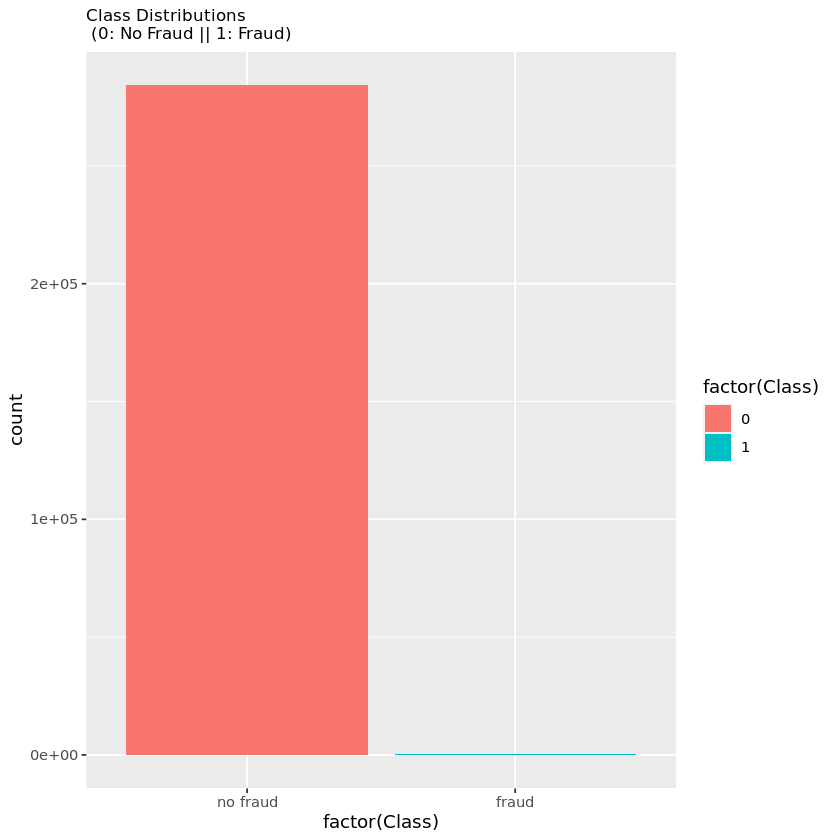

In [12]:
library(ggplot2)

ggplot(data_df, aes(x = factor(Class), fill = factor(Class))) +
  geom_bar(stat = "count") +
  scale_x_discrete(labels = c("no fraud", "fraud")) +
  ggtitle("Class Distributions \n (0: No Fraud || 1: Fraud)") +
  theme(plot.title = element_text(size = 10))

This plot clearly shows how imbalanced the dataset is.

### Show the five-number summary

Show the five-number summary (minimum score, first quartile, median, third quartile, and maximum score) for the transaction amount, with box plots:


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




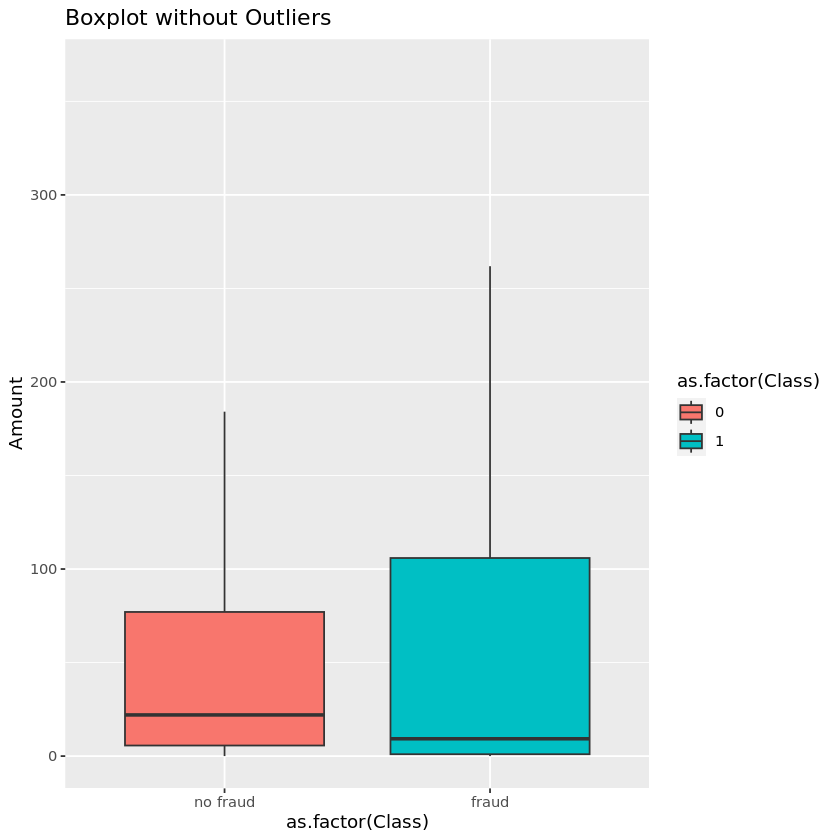

In [13]:
library(ggplot2)
library(dplyr)

ggplot(data_df, aes(x = as.factor(Class), y = Amount, fill = as.factor(Class))) +
  geom_boxplot(outlier.shape = NA) +
  scale_x_discrete(labels = c("no fraud", "fraud")) +
  ggtitle("Boxplot without Outliers") +
  coord_cartesian(ylim = quantile(data_df$Amount, c(0.05, 0.95)))

For highly imbalanced data, box plots might not show accurate insights. However, you can address the `Class` imbalance problem first, and then create the same plots for more accurate insights.

## Step 4: Train and evaluate the models

Here, you train a LightGBM model to classify the fraud transactions. You train a LightGBM model on both the imbalanced dataset and the balanced dataset. Then, you compare the performance of both models.

### Prepare training and test datasets

In [2]:
# Split the dataset into training and test datasets
set.seed(42)
train_sample_ids <- base::sample(seq_len(nrow(data_df)), size = floor(0.85 * nrow(data_df)))

train_df <- data_df[train_sample_ids, ]
test_df <- data_df[-train_sample_ids, ]

ERROR: Error in eval(expr, envir, enclos): object 'data_df' not found


In [1]:
test_df

ERROR: Error in eval(expr, envir, enclos): object 'test_df' not found


### Apply SMOTE to the training dataset

Imbalanced classification has a problem. It has too few minority class examples for a model to effectively learn the decision boundary. Synthetic Minority Oversampling Technique (SMOTE) can handle this problem. SMOTE is the most widely used approach to synthesize new samples for the minority class. You can access SMOTE by using the `imbalance` library that you installed in Step 1.

Apply SMOTE only to the training dataset, instead of the testing dataset. When you score the model with the test data, you need an approximation of the model performance on unseen data in production. For a valid approximation, your test data relies on the original imbalanced distribution to represent production data as closely as possible.

In [17]:
# Apply SMOTE to the training dataset
library(imbalance)

# Print the shape of the original (imbalanced) training dataset
train_y_categ <- train_df %>% select(Class) %>% table
message(
    paste0(
        "Original dataset shape ",
        paste(names(train_y_categ), train_y_categ, sep = ": ", collapse = ", ")
    )
)

# Resample the training dataset by using SMOTE
smote_train_df <- train_df %>%
    mutate(Class = factor(Class)) %>%
    oversample(ratio = 0.99, method = "SMOTE", classAttr = "Class") %>%
    mutate(Class = as.integer(as.character(Class)))

# Print the shape of the resampled (balanced) training dataset
smote_train_y_categ <- smote_train_df %>% select(Class) %>% table
message(
    paste0(
        "Resampled dataset shape ",
        paste(names(smote_train_y_categ), smote_train_y_categ, sep = ": ", collapse = ", ")
    )
)

Original dataset shape 0: 241667, 1: 418

Resampled dataset shape 0: 241667, 1: 239251



In [19]:
library(lightgbm)

ERROR: Error in library(lightgbm): there is no package called ‘lightgbm’


For more information about SMOTE, see the [Package 'imbalance'](https://cran.r-project.org/web/packages/imbalance/imbalance.pdf) and [Working with imbalanced datasets](https://cran.r-project.org/web/packages/imbalance/vignettes/imbalance.pdf) resources at the CRAN website.

### Train the model by using LightGBM

Train the LightGBM model with both the imbalanced dataset and the balanced (via SMOTE) dataset. Then, compare their performance:

In [23]:
# Train LightGBM for both imbalanced and balanced datasets and define the evaluation metrics
library(lightgbm)

# Get the ID of the label column
label_col <- which(names(train_df) == "Class")

# Convert the testing dataset for the model
test_mtx <- as.matrix(test_df)
test_x <- test_mtx[, -label_col]
test_y <- test_mtx[, label_col]

# Set up the parameters for training
params <- list(
    objective = "binary",
    learning_rate = 0.05,
    first_metric_only = TRUE
)

# Train for the imbalanced dataset
message("Start training with imbalanced data:")
train_mtx <- as.matrix(train_df)
train_x <- train_mtx[, -label_col]
train_y <- train_mtx[, label_col]
train_data <- lgb.Dataset(train_x, label = train_y)
valid_data <- lgb.Dataset.create.valid(train_data, test_x, label = test_y)
model <- lgb.train(
    data = train_data,
    params = params,
    eval = list("binary_logloss", "auc"),
    valids = list(valid = valid_data),
    nrounds = 300L
)

# Train for balanced (via SMOTE) dataset   
message("\n\nStart training with balanced data:")
smote_train_mtx <- as.matrix(smote_train_df)
smote_train_x <- smote_train_mtx[, -label_col]
smote_train_y <- smote_train_mtx[, label_col]
smote_train_data <- lgb.Dataset(smote_train_x, label = smote_train_y)
smote_valid_data <- lgb.Dataset.create.valid(smote_train_data, test_x, label = test_y)
smote_model <- lgb.train(
    data = smote_train_data,
    params = params,
    eval = list("binary_logloss", "auc"),
    valids = list(valid = smote_valid_data),
    nrounds = 300L
)

Start training with imbalanced data:



Start training with balanced data:



[LightGBM] [Info] Number of positive: 418, number of negative: 241667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 242085, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001727 -> initscore=-6.359835
[LightGBM] [Info] Start training from score -6.359835
[1]:  valid's binary_logloss:0.00594494  valid's auc:0.895445 
[2]:  valid's binary_logloss:0.0135924  valid's auc:0.678966 
[3]:  valid's binary_logloss:0.00943818  valid's auc:0.828012 
[4]:  valid's binary_logloss:0.00835686  valid's auc:0.868802 
[5]:  valid's binary_logloss:0.00853258  valid's auc:0.852436 
[6]:  valid's binary_logloss:0.00832369  valid's auc:0.85116 
[7]:  valid's binary_logloss:0.00822669  valid's auc:0.864437 
[8]:  valid's binary_logloss:0.00813175  valid's auc:0.864756 
[9]:

### Determine feature importance

For the model that you trained on the balanced (via SMOTE) dataset, calculate the feature importance:

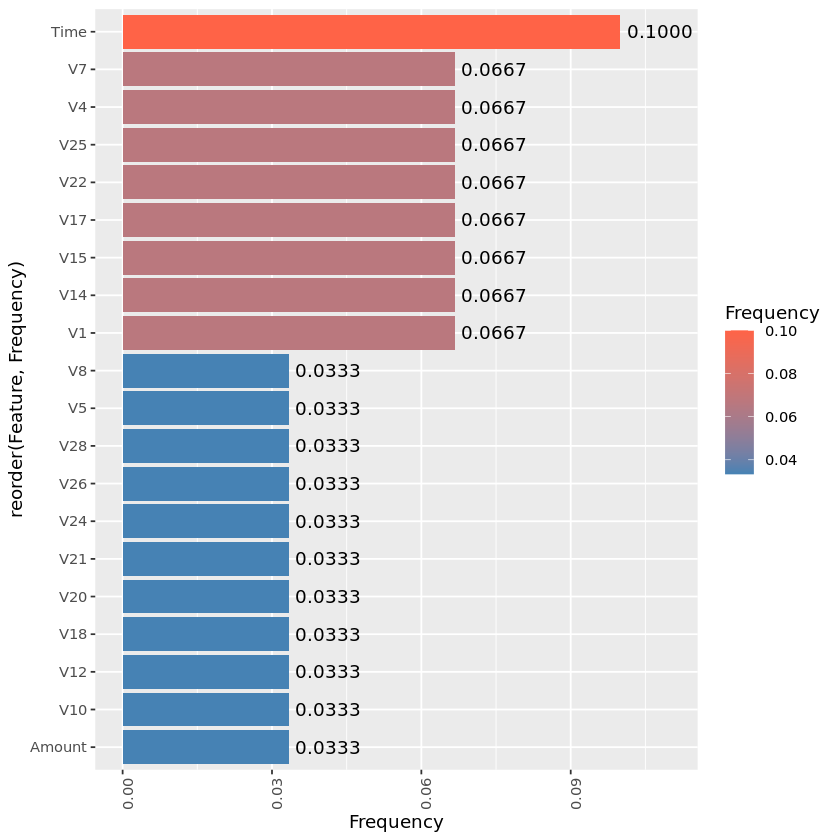

In [24]:
imp <- lgb.importance(model, percentage = TRUE)
ggplot(imp, aes(x = Frequency, y = reorder(Feature, Frequency), fill = Frequency)) +
  scale_fill_gradient(low="steelblue", high="tomato") +
  geom_bar(stat = "identity") +
  geom_text(aes(label = sprintf("%.4f", Frequency)), hjust = -0.1) +
  theme(axis.text.x = element_text(angle = 90)) +
  xlim(0, max(imp$Frequency) * 1.1)

Determine the feature importance for the model that you trained on the balanced (via SMOTE) dataset:

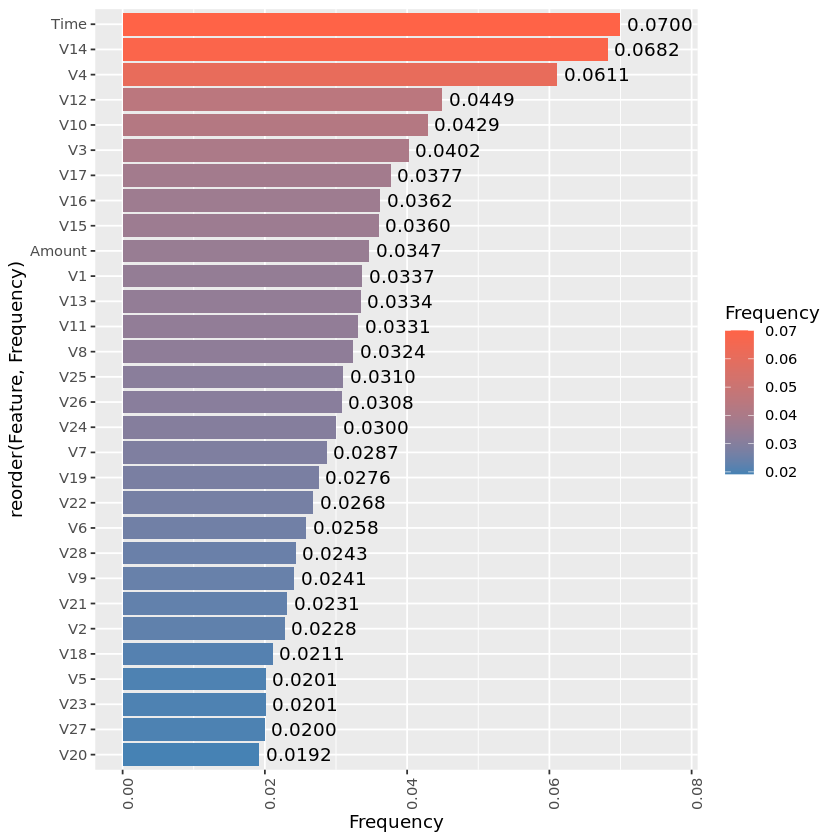

In [25]:
smote_imp <- lgb.importance(smote_model, percentage = TRUE)
ggplot(smote_imp, aes(x = Frequency, y = reorder(Feature, Frequency), fill = Frequency)) +
  geom_bar(stat = "identity") +
  scale_fill_gradient(low="steelblue", high="tomato") +
  geom_text(aes(label = sprintf("%.4f", Frequency)), hjust = -0.1) +
  theme(axis.text.x = element_text(angle = 90)) +
  xlim(0, max(smote_imp$Frequency) * 1.1)

A comparison of these plots clearly shows that balanced and imbalanced training datasets have large feature importance differences.

#### Evaluate the models

Here, you evaluate the two trained models:

- `model` trained on raw, imbalanced data
- `smote_model` trained on balanced data

In [26]:
preds <- predict(model, test_mtx[, -label_col])
smote_preds <- predict(smote_model, test_mtx[, -label_col])

### Evaluate model performance with a confusion matrix

A *confusion matrix* displays the number of:

* true positives (TP)
* true negatives (TN)
* false positives (FP)
* false negatives (FN)

that a model produces when scored with test data. For binary classification, the model returns a `2x2` confusion matrix. For multiclass classification, the model returns an `nxn` confusion matrix, where `n` is the number of classes.

Use a confusion matrix to summarize the performance of the trained machine learning models on the test data:

In [27]:
plot_cm <- function(preds, refs, title) {
    library(caret)
    cm <- confusionMatrix(factor(refs), factor(preds))
    cm_table <- as.data.frame(cm$table)
    cm_table$Prediction <- factor(cm_table$Prediction, levels=rev(levels(cm_table$Prediction)))

    ggplot(cm_table, aes(Reference, Prediction, fill = Freq)) +
            geom_tile() +
            geom_text(aes(label = Freq)) +
            scale_fill_gradient(low = "white", high = "steelblue", trans = "log") +
            labs(x = "Prediction", y = "Reference", title = title) +
            scale_x_discrete(labels=c("0", "1")) +
            scale_y_discrete(labels=c("1", "0")) +
            coord_equal() +
            theme(legend.position = "none")
}

Plot the confusion matrix for the model trained on the imbalanced dataset:

StatementMeta(, 1a89a9fe-074a-4632-a48a-c4402d9807ce, 21, Finished, Available)

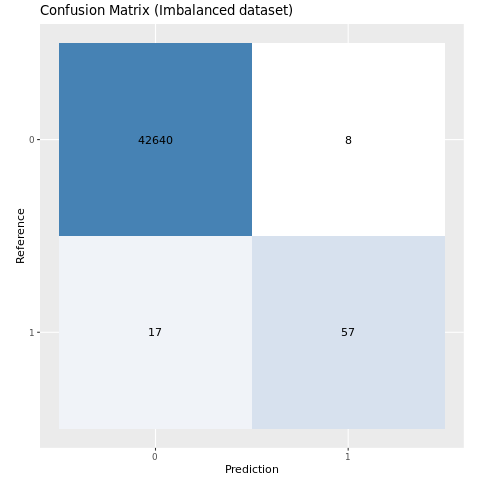

In [ ]:
# The value of the prediction indicates the probability that a transaction is a fraud
# Use 0.5 as the threshold for fraud/no-fraud transactions
plot_cm(ifelse(preds > 0.5, 1, 0), test_df$Class, "Confusion Matrix (Imbalanced dataset)")

Plot the confusion matrix for the model trained on the balanced dataset:

Loading required package: lattice



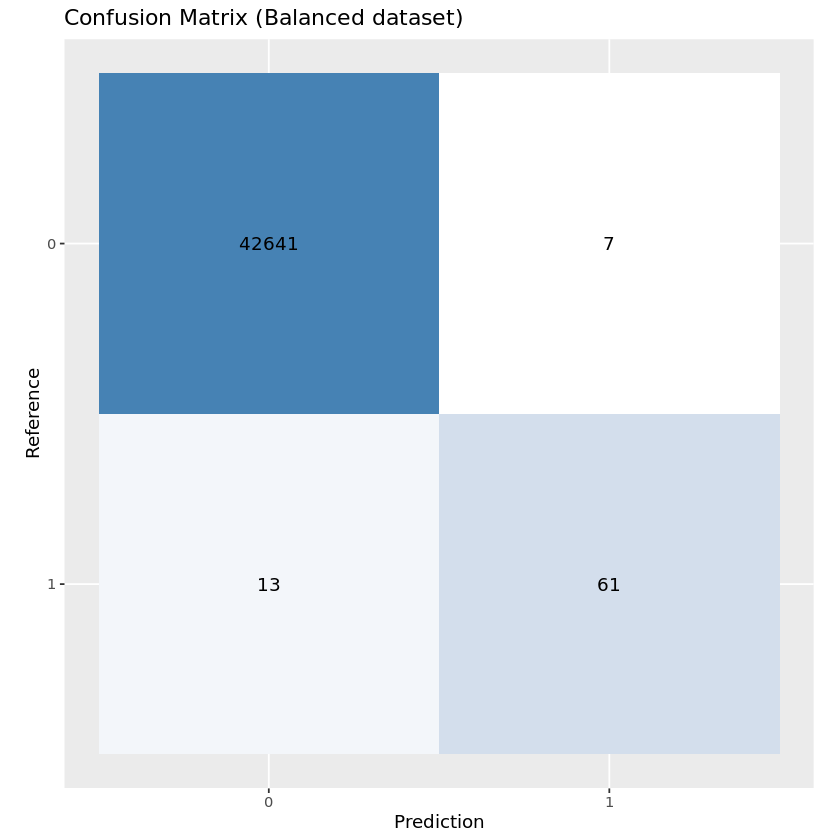

In [28]:
plot_cm(ifelse(smote_preds > 0.5, 1, 0), test_df$Class, "Confusion Matrix (Balanced dataset)")

### Evaluate model performance with AUC-ROC and AUPRC measures

The Area Under the Curve Receiver Operating Characteristic (AUC-ROC) measure assesses the performance of binary classifiers. The AUC-ROC chart visualizes the trade-off between the true positive rate (TPR) and the false positive rate (FPR).

In some cases, it's more appropriate to eIn some cases, it's more appropriate to evaluate your classifier based on the Area Under the Precision-Recall Curve (AUPRC) measure. The AUPRC is a curve that combines these rates:

- The precision, or the positive predictive value (PPV)
- The recall, or TPR

In [29]:
# Use the PRROC package to help calculate and plot AUC-ROC and AUPRC
install.packages("PRROC", quiet = TRUE)
library(PRROC)

#### Calculate the AUC-ROC and AUPRC metrics

Calculate and plot the AUC-ROC and AUPRC metrics for the two models.

### **Imbalanced dataset**

In [30]:
fg <- preds[test_df$Class == 1]
bg <- preds[test_df$Class == 0]

Print the area under the AUC-ROC curve:

In [32]:
# Compute AUC-ROC
roc <- roc.curve(scores.class0 = fg, scores.class1 = bg, curve = TRUE)
print(roc)


  ROC curve

    Area under curve:
     0.8954433 

    Curve for scores from  0.001642452  to  1 
    ( can be plotted with plot(x) )



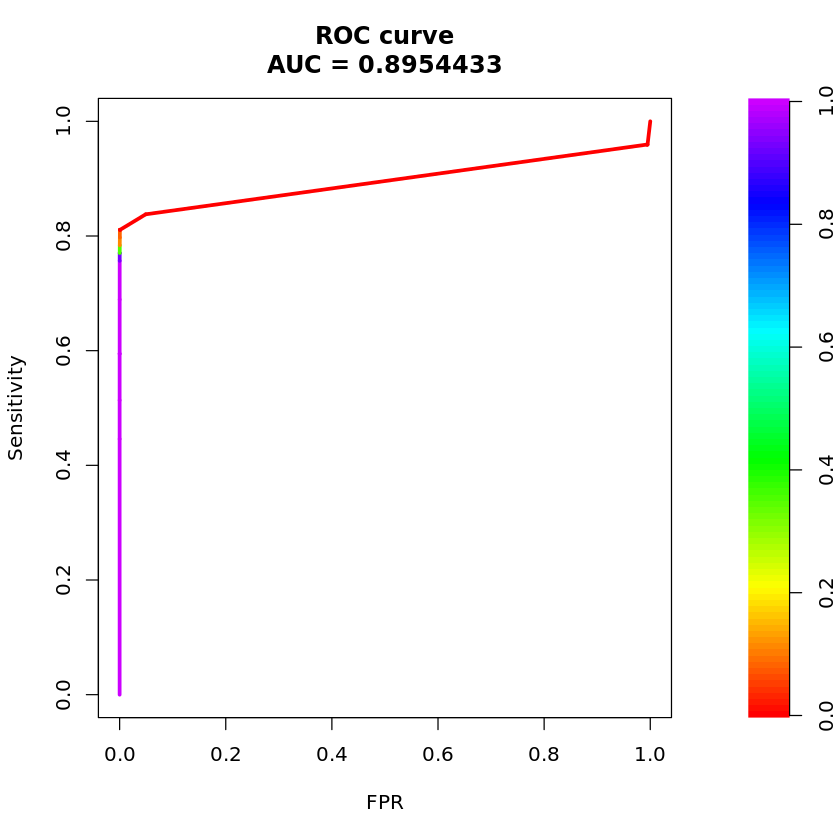

In [33]:
# Plot AUC-ROC
plot(roc)

Print the AUPRC curve:

In [34]:
# Compute AUPRC
pr <- pr.curve(scores.class0 = fg, scores.class1 = bg, curve = TRUE)
print(pr)


  Precision-recall curve

    Area under curve (Integral):
     0.7928619 

    Area under curve (Davis & Goadrich):
     0.7955138 

    Curve for scores from  0.001642452  to  1 
    ( can be plotted with plot(x) )



Plot the AUPRC curve:

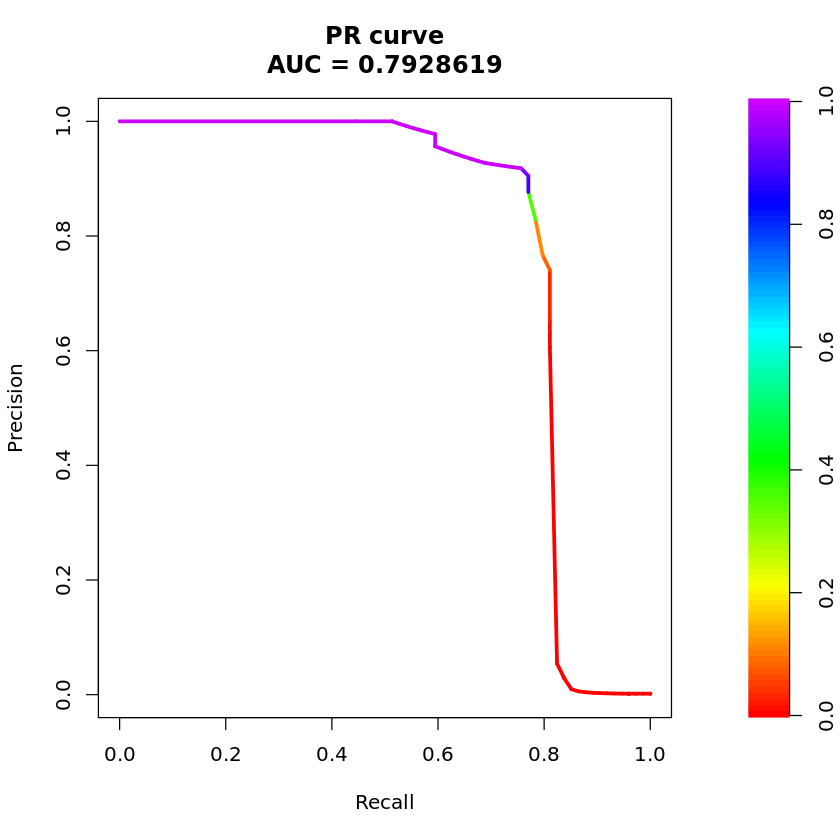

In [35]:
# Plot AUPRC
plot(pr)

#### Balanced (via SMOTE) dataset

Calculate the predictions:

In [36]:
smote_fg <- smote_preds[test_df$Class == 1]
smote_bg <- smote_preds[test_df$Class == 0]

Print the AUC-ROC curve:

In [37]:
# Compute AUC-ROC
smote_roc <- roc.curve(scores.class0 = smote_fg, scores.class1 = smote_bg, curve = TRUE)
print(smote_roc)


  ROC curve

    Area under curve:
     0.9682134 

    Curve for scores from  8.1973e-16  to  0.9999987 
    ( can be plotted with plot(x) )



Plot the AUC-ROC curve:

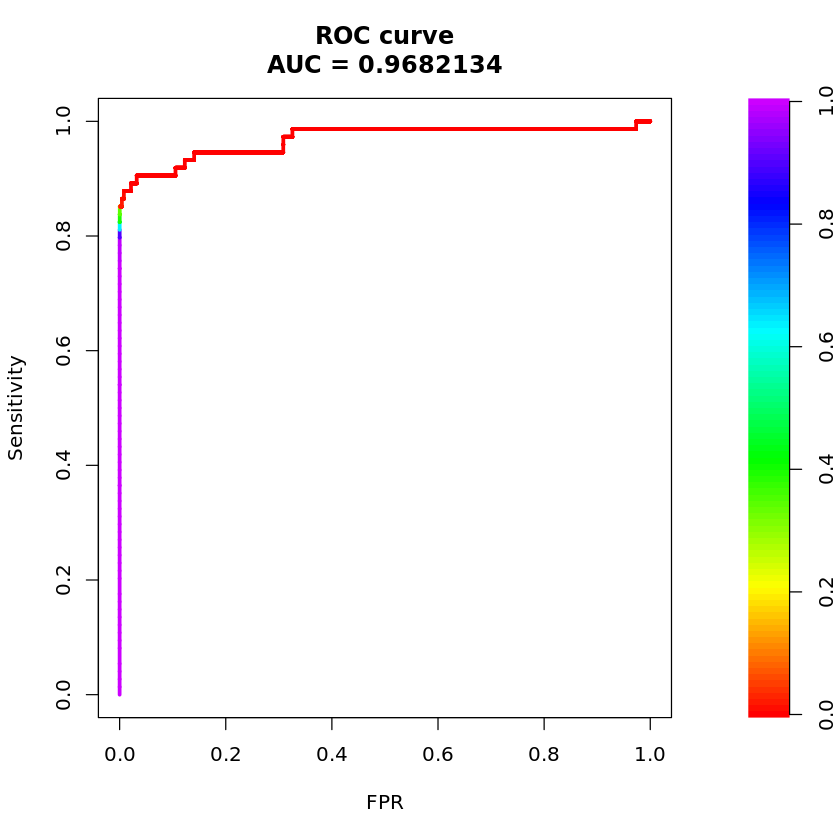

In [38]:
# Plot AUC-ROC
plot(smote_roc)

In [39]:
# Compute AUPRC
smote_pr <- pr.curve(scores.class0 = smote_fg, scores.class1 = smote_bg, curve = TRUE)
print(smote_pr)


  Precision-recall curve

    Area under curve (Integral):
     0.8377414 

    Area under curve (Davis & Goadrich):
     0.8377397 

    Curve for scores from  8.1973e-16  to  0.9999987 
    ( can be plotted with plot(x) )



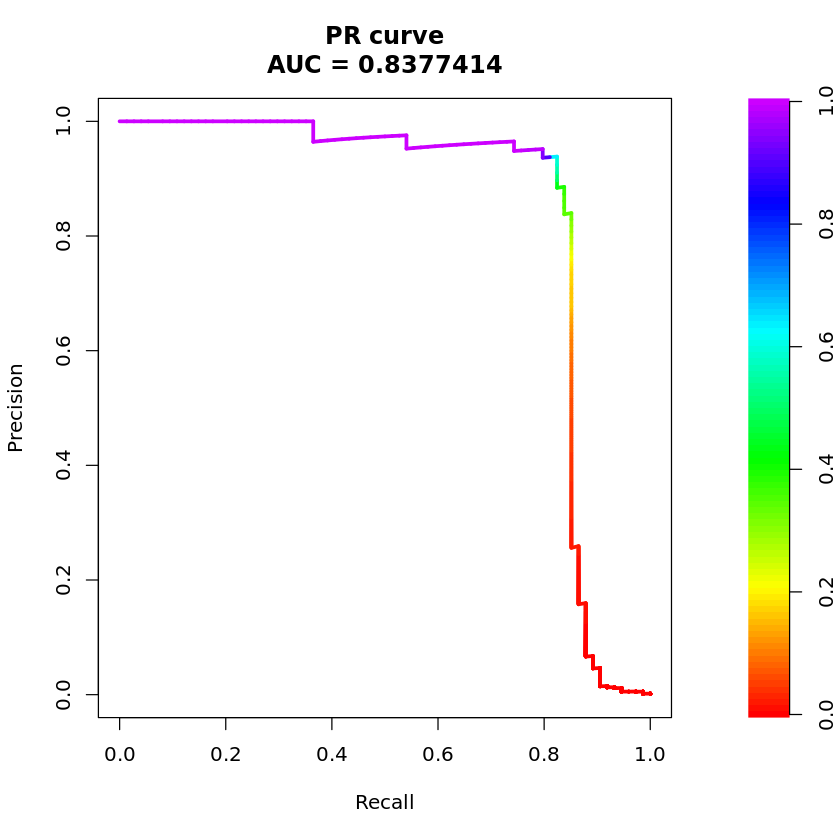

In [40]:
# Plot AUPRC
plot(smote_pr)

The earlier figures clearly show that the model trained on the balanced dataset outperforms the model trained on the imbalanced dataset, for both AUC-ROC and AUPRC scores. This result suggests that SMOTE effectively improves model performance when working with highly imbalanced data.